## План практического занятия:
#### 1) Загрузка и пояснения нового класса для работы с базой PostgreSQL
#### 2) Импорт необходимых библиотек
#### 3) Загрузка данных
#### 4) Примеры запросов
#### 5) Домашнее задание

Cтруктура:
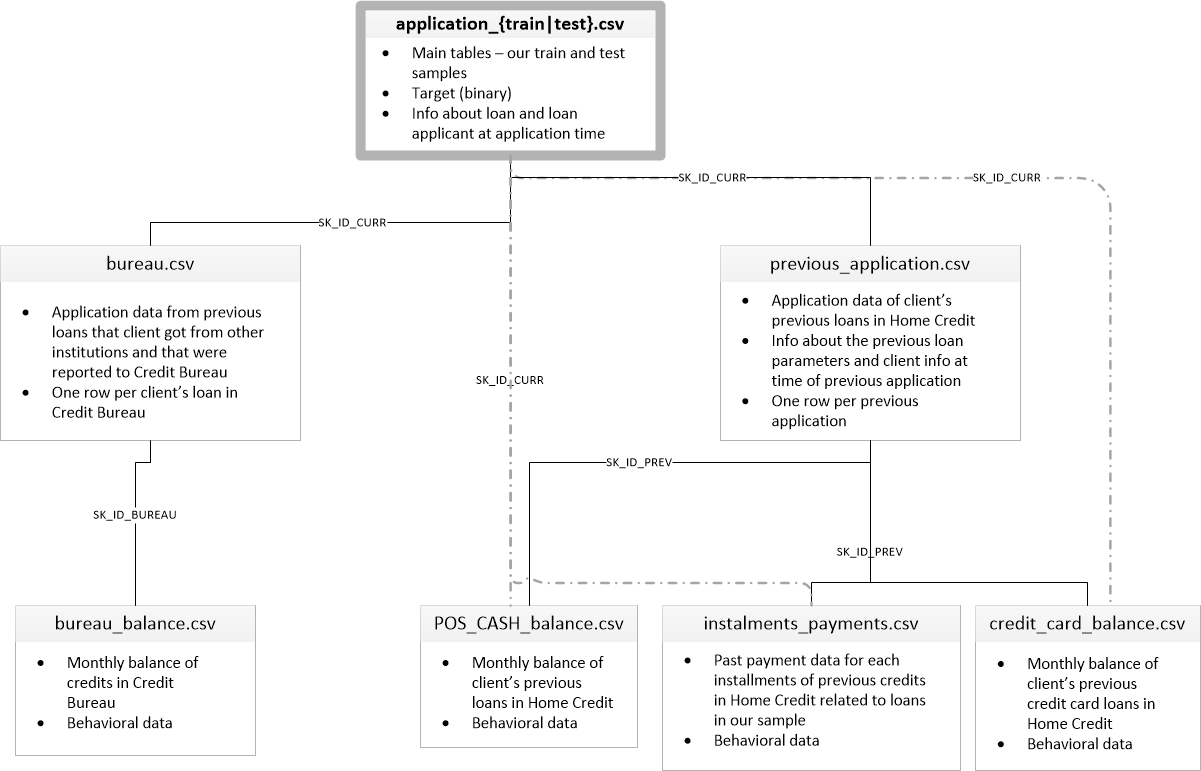

Для удобства использования базы данных и её редактирования в файле `db_handler.py` реализован класс PostgresDBHandler, который имеет функции:


• Подключаться к базе данных

    Считывает параметры подключения из конфигурационного файла (формат INI).
    Метод: connect()
    
• Закрывать соединение

    Метод: close()

• Выполнять произвольные SQL‑запросы (DDL/DML)

    Подходит для создания, изменения схемы, вставки данных и т.д.
    Метод: execute_query(query, params=None)

• Получать результаты запросов в виде DataFrame

    Выполняет SELECT‑запрос и возвращает результат в формате pandas DataFrame.
    Метод: get_df_from_query(query, params=None)

• Создавать таблицы с заранее определённой схемой

    Принимает имя таблицы и словарь, где ключ – имя столбца, а значение – тип столбца (например, "id": "SERIAL").
    Метод: create_table(table_name, columns, drop_if_exists=False)

• Устанавливать первичные ключи (внутренние ключи)

    Если таблица создана без указания первичного ключа или требуется изменить его, можно задать один или несколько столбцов как первичный ключ.
    Метод: establish_primary_key(table_name, columns, constraint_name=None)

• Устанавливать внешние ключи (связи между таблицами)

    Связывает столбец одной таблицы с соответствующим столбцом в другой (обычно с первичным или уникальным ключом).
    Метод: establish_relationship(table_name, column_name, ref_table, ref_column, constraint_name)

• Загружать данные из CSV-файла в таблицу

    Использует команду COPY FROM (через метод copy_expert), чтобы загрузить данные из локального CSV-файла в указанную таблицу.
    Метод: load_table_from_csv(table_name, csv_file_path, delimiter=',', header=True)

## Импортируем необходимые библиотеки

In [ ]:
import sys
sys.path.append(r'C:\Users\Denis\credit_scoring\src\app\utils')
sys.path.append(r"C:\Users\Denis\credit_scoring\src\config")
from db_handler import PostgresDBHandler
from db_config import DB_ARGS
import pandas as pd

## Загрузка таблиц

### Загрузка таблицы `bureau`

Создадим объект класса PostgresDBHandler, который будет использоваться для работы с базой данных PostgreSQL

In [6]:
# Создание экземпляра класса PostgresDBHandler с указанием пути к файлу конфигурации
db_handler = PostgresDBHandler(db_args=DB_ARGS)
db_handler.connect()

Соединение с PostgreSQL установлено.


Так как у нас БД уже создана, то загрузим табличку. Сначала нужно создать структуру.

In [10]:
sql_schema_query = {
    "SK_ID_CURR":"integer",
    "SK_BUREAU_ID": "integer",
    "CREDIT_ACTIVE": "varchar(13)",
    "CREDIT_CURRENCY": "varchar(15)",
    "DAYS_CREDIT": "smallint",
    "CREDIT_DAY_OVERDUE": "smallint",
    "DAYS_CREDIT_ENDDATE": "real",
    "DAYS_ENDDATE_FACT": "real",
    "AMT_CREDIT_MAX_OVERDUE": "real",
    "CNT_CREDIT_PROLONG": "smallint",
    "AMT_CREDIT_SUM": "real",
    "AMT_CREDIT_SUM_DEBT": "real",
    "AMT_CREDIT_SUM_LIMIT": "real",
    "AMT_CREDIT_SUM_OVERDUE": "real",
    "CREDIT_TYPE": "varchar(49)",
    "DAYS_CREDIT_UPDATE": "integer",
    "AMT_ANNUITY": "real"}


In [11]:
%%time

db_handler.create_table('bureau', sql_schema_query, drop_if_exists=True)

Таблица bureau удалена (если существовала).
Таблица bureau успешно создана.
CPU times: total: 0 ns
Wall time: 115 ms


Теперь "зальем" данные.

In [12]:
%%time

db_handler.load_table_from_csv('bureau', r"C:\data\bureau.csv", delimiter=',', header=True)

Данные успешно загружены в таблицу bureau.
CPU times: total: 641 ms
Wall time: 11.2 s


Проверяем

In [6]:
sql_query = """
    SELECT * 
    FROM bureau 
"""

In [7]:
%%time
df = db_handler.get_df_from_query(sql_query)

C:\Users\Denis\credit_scoring\src\app\utils\db_handler.py:80: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, self.connection, params=params)


CPU times: total: 12.7 s
Wall time: 15.4 s


In [8]:
df.head(5)

,sk_id_curr,sk_bureau_id,credit_active,credit_currency,days_credit,credit_day_overdue,days_credit_enddate,days_enddate_fact,amt_credit_max_overdue,cnt_credit_prolong,amt_credit_sum,amt_credit_sum_debt,amt_credit_sum_limit,amt_credit_sum_overdue,credit_type,days_credit_update,amt_annuity
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


Отлично! Таблица загруженна, идём далее!

### Загрузка таблицы `bureau_balance`

Таблица имеет признак STATUS, который является категориальным, с  фиксированым кол-вом и многообразием категорий, поэтому присвоем признаку тип ENUM

In [9]:
enum_query = """
    DO $$
    BEGIN
        IF NOT EXISTS (SELECT 1 FROM pg_type WHERE typname = 'status_enum') THEN
            CREATE TYPE status_enum AS ENUM (
                'C',  -- Closed
                'X',  -- Unknown
                '0',  -- No DPD
                '1',  -- DPD 1-30
                '2',  -- DPD 31-60
                '3',  -- DPD 61-90
                '4',  -- DPD 91-120
                '5'   -- DPD 120+ or sold/written off
            );
        END IF;
    END
    $$;
    """
db_handler.execute_query(enum_query)


Создадим структуру таблицы и определим её название

In [10]:
table_name = "bureau_balance"
sql_schema_query = {
    "SK_BUREAU_ID": "bigint",
    "MONTHS_BALANCE": "integer",
    "STATUS": "status_enum"
}

Приступим непосредственно к созданию

In [11]:
db_handler.create_table(table_name, sql_schema_query, drop_if_exists=True)

Таблица bureau_balance удалена (если существовала).
Таблица bureau_balance успешно создана.


Загрузим данные 

In [12]:
db_handler.load_table_from_csv('bureau_balance', r"C:\data\bureau_balance.csv", delimiter=',', header=True)

Данные успешно загружены в таблицу bureau_balance.


Непосредственно проверяем

In [13]:
%%time
sql_query = """
    SELECT * 
    FROM bureau_balance
    LIMIT 10
"""

df = db_handler.get_df_from_query(sql_query)

CPU times: total: 0 ns
Wall time: 161 ms


C:\Users\Denis\credit_scoring\src\app\utils\db_handler.py:80: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, self.connection, params=params)


In [14]:
df.head(5)

,sk_bureau_id,months_balance,status
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


Отлично! Переходим к следующей таблице!

### Загрузка таблицы `POS_CASH_balance`

В этой таблице тоже есть признак с похожим категориальным признаком как STATUS, определим его тип аналогично, ENUM

In [15]:
sql_query = """
    CREATE TYPE contract_status_name_enum AS ENUM (
    'Active', 'Closed', 'Signed', 'Approved', 'Completed')
    """
db_handler.execute_query(sql_query)

Ошибка при выполнении запроса: ОШИБКА:  тип "contract_status_name_enum" уже существует



In [16]:
db_handler.connect()

Соединение с PostgreSQL установлено.


Определим название таблицы и её структуру

In [17]:
table_name = "pos_cash_balance"
sql_schema_query = {
    "SK_ID_PREV": "bigint",                # Уникальный идентификатор предыдущего кредита
    "SK_ID_CURR": "bigint",                # Уникальный идентификатор текущего кредита
    "MONTHS_BALANCE": "integer",           # Месяц баланса относительно даты заявки
    "CNT_INSTALMENT": "real",           # Количество платежей по кредиту
    "CNT_INSTALMENT_FUTURE": "real",    # Количество оставшихся платежей
    "NAME_CONTRACT_STATUS": "text",        # Статус контракта (например, Active, Closed)
    "SK_DPD": "integer",                   # Количество дней просрочки (DPD)
    "SK_DPD_DEF": "integer"                # Количество дней просрочки по дефолту
}


Создадим таблицу и загрузим туда данные

In [18]:
db_handler.create_table(table_name, sql_schema_query, drop_if_exists=True)
db_handler.load_table_from_csv('pos_cash_balance', r"C:\data\POS_CASH_balance.csv", delimiter=',', header=True)

Таблица pos_cash_balance удалена (если существовала).
Таблица pos_cash_balance успешно создана.
Данные успешно загружены в таблицу pos_cash_balance.


Проверяем

In [19]:
%%time
sql_query = """
    SELECT * 
    FROM pos_cash_balance
    LIMIT 10
"""

df = db_handler.get_df_from_query(sql_query)
df


CPU times: total: 0 ns
Wall time: 7 ms


C:\Users\Denis\credit_scoring\src\app\utils\db_handler.py:80: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, self.connection, params=params)


,sk_id_prev,sk_id_curr,months_balance,cnt_instalment,cnt_instalment_future,name_contract_status,sk_dpd,sk_dpd_def
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0
5,2207092,342166,-32,12.0,12.0,Active,0,0
6,1110516,204376,-38,48.0,43.0,Active,0,0
7,1387235,153211,-35,36.0,36.0,Active,0,0
8,1220500,112740,-31,12.0,12.0,Active,0,0
9,2371489,274851,-32,24.0,16.0,Active,0,0


### Загрузка таблицы `credit_card_balance`

Определим структуру таблицы и её название



In [20]:
table_name = "credit_card_balance"
sql_schema_query = {
    "SK_ID_PREV": "bigint",                        # Уникальный идентификатор предыдущего кредита
    "SK_ID_CURR": "bigint",                        # Уникальный идентификатор текущего кредита
    "MONTHS_BALANCE": "integer",                   # Месяц баланса относительно даты заявки
    "AMT_BALANCE": "numeric",                      # Текущий баланс (денежное значение)
    "AMT_CREDIT_LIMIT_ACTUAL": "numeric",          # Текущий кредитный лимит (денежное значение)
    "AMT_DRAWINGS_ATM_CURRENT": "numeric",         # Сумма снятий через банкомат (денежное значение)
    "AMT_DRAWINGS_CURRENT": "numeric",             # Общая сумма снятий (денежное значение)
    "AMT_DRAWINGS_OTHER_CURRENT": "numeric",       # Сумма снятий через другие каналы (денежное значение)
    "AMT_DRAWINGS_POS_CURRENT": "numeric",         # Сумма снятий через POS-терминалы (денежное значение)
    "AMT_INST_MIN_REGULARITY": "numeric",          # Минимальная сумма регулярного платежа (денежное значение)
    "AMT_PAYMENT_CURRENT": "numeric",              # Текущая сумма платежа (денежное значение)
    "AMT_PAYMENT_TOTAL_CURRENT": "numeric",        # Общая сумма текущих платежей (денежное значение)
    "AMT_RECEIVABLE_PRINCIPAL": "numeric",         # Основная сумма задолженности (денежное значение)
    "AMT_RECIVABLE": "numeric",                    # Сумма задолженности (денежное значение)
    "AMT_TOTAL_RECEIVABLE": "numeric",             # Общая сумма задолженности (денежное значение)
    "CNT_DRAWINGS_ATM_CURRENT": "real",         # Количество снятий через банкомат
    "CNT_DRAWINGS_CURRENT": "integer",             # Общее количество снятий
    "CNT_DRAWINGS_OTHER_CURRENT": "real",       # Количество снятий через другие каналы
    "CNT_DRAWINGS_POS_CURRENT": "real",         # Количество снятий через POS-терминалы
    "CNT_INSTALMENT_MATURE_CUM": "real",        # Общее количество завершенных платежей
    "NAME_CONTRACT_STATUS": "text",                # Статус контракта (например, Active, Closed)
    "SK_DPD": "integer",                           # Количество дней просрочки (DPD)
    "SK_DPD_DEF": "integer"                        # Количество дней просрочки по дефолту
}


Создадим таблицу и зальём данные

In [21]:
db_handler.connect()

Соединение с PostgreSQL установлено.


In [22]:
db_handler.create_table(table_name, sql_schema_query, drop_if_exists=True)
db_handler.load_table_from_csv('credit_card_balance', r"C:\data\credit_card_balance.csv", delimiter=',', header=True)

Таблица credit_card_balance удалена (если существовала).
Таблица credit_card_balance успешно создана.
Данные успешно загружены в таблицу credit_card_balance.


Проверяем

In [23]:
%%time
sql_query = """
    SELECT * 
    FROM credit_card_balance
    LIMIT 10
"""

df = db_handler.get_df_from_query(sql_query)
df

CPU times: total: 15.6 ms
Wall time: 8 ms


C:\Users\Denis\credit_scoring\src\app\utils\db_handler.py:80: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, self.connection, params=params)


,sk_id_prev,sk_id_curr,months_balance,amt_balance,amt_credit_limit_actual,amt_drawings_atm_current,amt_drawings_current,amt_drawings_other_current,amt_drawings_pos_current,amt_inst_min_regularity,...,amt_recivable,amt_total_receivable,cnt_drawings_atm_current,cnt_drawings_current,cnt_drawings_other_current,cnt_drawings_pos_current,cnt_instalment_mature_cum,name_contract_status,sk_dpd,sk_dpd_def
0,2562384,378907,-6,56.970,135000.0,0.0,877.500,0.0,877.500,1700.325,...,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000.0,2250.0,2250.000,0.0,0.000,2250.000,...,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000.0,0.0,0.000,0.0,0.000,2250.000,...,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000.0,2250.0,2250.000,0.0,0.000,11795.760,...,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000.0,0.0,11547.000,0.0,11547.000,22924.890,...,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0
5,2646502,380010,-7,82903.815,270000.0,0.0,0.000,0.0,0.000,4449.105,...,82773.315,82773.315,0.0,0,0.0,0.0,2.0,Active,7,0
6,1079071,171320,-6,353451.645,585000.0,67500.0,67500.000,0.0,0.000,14684.175,...,351881.145,351881.145,1.0,1,0.0,0.0,6.0,Active,0,0
7,2095912,118650,-7,47962.125,45000.0,45000.0,45000.000,0.0,0.000,0.000,...,47962.125,47962.125,1.0,1,0.0,0.0,51.0,Active,0,0
8,2181852,367360,-4,291543.075,292500.0,90000.0,289339.425,0.0,199339.425,130.500,...,286831.575,286831.575,3.0,8,0.0,5.0,3.0,Active,0,0
9,1235299,203885,-5,201261.195,225000.0,76500.0,111026.700,0.0,34526.700,6338.340,...,197224.695,197224.695,3.0,9,0.0,6.0,38.0,Active,0,0


Идём далее!)

### Создание таблицы `previous_application`

Определим структуру и название таблицы

In [24]:
table_name = "previous_application"
sql_schema_query = {
    "sk_id_prev": "bigint",                        # Уникальный идентификатор предыдущего кредита
    "sk_id_curr": "bigint",                        # Уникальный идентификатор текущего кредита
    "name_contract_type": "text",                  # Тип контракта (например, Consumer loans, Cash loans)
    "amt_annuity": "numeric",                      # Аннуитетный платеж (денежное значение)
    "amt_application": "numeric",                  # Запрошенная сумма кредита (денежное значение)
    "amt_credit": "numeric",                       # Одобренная сумма кредита (денежное значение)
    "amt_down_payment": "numeric",                 # Сумма первоначального взноса (денежное значение)
    "amt_goods_price": "numeric",                  # Стоимость товара (денежное значение)
    "weekday_appr_process_start": "text",          # День недели, когда начался процесс заявки
    "hour_appr_process_start": "integer",          # Час, когда начался процесс заявки
    "flag_last_appl_per_contract": "boolean",      # Флаг последней заявки по контракту (Y/N)
    "nflag_last_appl_in_day": "boolean",           # Флаг последней заявки за день (1/0)
    "rate_down_payment": "numeric",                # Процент первоначального взноса
    "rate_interest_primary": "numeric",            # Основная процентная ставка (если доступна)
    "rate_interest_privileged": "numeric",         # Льготная процентная ставка (если доступна)
    "name_cash_loan_purpose": "text",              # Цель кредита (например, Repairs, Everyday expenses)
    "name_contract_status": "text",                # Статус контракта (например, Approved, Refused, Canceled)
    "days_decision": "integer",                    # Количество дней с момента принятия решения
    "name_payment_type": "text",                   # Тип платежа (например, Cash through the bank)
    "code_reject_reason": "text",                  # Причина отказа (например, XAP, HC)
    "name_type_suite": "text",                     # Тип сопровождающего лица (например, Family, Alone)
    "name_client_type": "text",                    # Тип клиента (например, New, Repeater)
    "name_goods_category": "text",                 # Категория товара (например, Mobile, Repairs)
    "name_portfolio": "text",                      # Портфель (например, POS, Cash)
    "name_product_type": "text",                   # Тип продукта (например, Walk-in, X-sell)
    "channel_type": "text",                        # Канал подачи заявки (например, Country-wide, Contact center)
    "sellerplace_area": "integer",                 # Площадь продавца (в квадратных метрах)
    "name_seller_industry": "text",                # Отрасль продавца (например, Connectivity, Consumer electronics)
    "cnt_payment": "numeric",                      # Количество платежей (может быть дробным)
    "name_yield_group": "text",                    # Группа доходности (например, middle, high)
    "product_combination": "text",                 # Комбинация продуктов (например, POS mobile with interest)
    "days_first_drawing": "numeric",               # Количество дней до первого снятия средств (может быть NULL)
    "days_first_due": "numeric",                   # Количество дней до первого платежа (может быть NULL)
    "days_last_due_1st_version": "numeric",        # Количество дней до последнего платежа (первая версия, может быть NULL)
    "days_last_due": "numeric",                    # Количество дней до последнего платежа (может быть NULL)
    "days_termination": "numeric",                 # Количество дней до завершения контракта (может быть NULL)
    "nflag_insured_on_approval": "numeric"         # Флаг страхования при одобрении (1/0)
}

Создадим её и зальём данные

In [31]:
db_handler.connect()

Соединение с PostgreSQL установлено.


In [26]:
db_handler.create_table(table_name, sql_schema_query, drop_if_exists=True)
db_handler.load_table_from_csv('previous_application', r"C:\data\previous_application.csv", delimiter=',', header=True)

Таблица previous_application удалена (если существовала).
Таблица previous_application успешно создана.
Данные успешно загружены в таблицу previous_application.


Отлично! сделаем проверку

In [27]:
%%time
sql_query = """
    SELECT * FROM previous_application
    LIMIT 10
"""

df = db_handler.get_df_from_query(sql_query)
df

CPU times: total: 15.6 ms
Wall time: 11 ms


C:\Users\Denis\credit_scoring\src\app\utils\db_handler.py:80: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, self.connection, params=params)


,sk_id_prev,sk_id_curr,name_contract_type,amt_annuity,amt_application,amt_credit,amt_down_payment,amt_goods_price,weekday_appr_process_start,hour_appr_process_start,...,name_seller_industry,cnt_payment,name_yield_group,product_combination,days_first_drawing,days_first_due,days_last_due_1st_version,days_last_due,days_termination,nflag_insured_on_approval
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN
5,1383531,199383,Cash loans,23703.930,315000.0,340573.5,NaN,315000.0,SATURDAY,8,...,XNA,18.0,low_normal,Cash X-Sell: low,365243.0,-654.0,-144.0,-144.0,-137.0,1.0
6,2315218,175704,Cash loans,NaN,0.0,0.0,NaN,NaN,TUESDAY,11,...,XNA,NaN,XNA,Cash,NaN,NaN,NaN,NaN,NaN,NaN
7,1656711,296299,Cash loans,NaN,0.0,0.0,NaN,NaN,MONDAY,7,...,XNA,NaN,XNA,Cash,NaN,NaN,NaN,NaN,NaN,NaN
8,2367563,342292,Cash loans,NaN,0.0,0.0,NaN,NaN,MONDAY,15,...,XNA,NaN,XNA,Cash,NaN,NaN,NaN,NaN,NaN,NaN
9,2579447,334349,Cash loans,NaN,0.0,0.0,NaN,NaN,SATURDAY,15,...,XNA,NaN,XNA,Cash,NaN,NaN,NaN,NaN,NaN,NaN


Прекрасно! Идём дальше

### Создание таблицы `installments_payments`


Аналогично создадим структуру таблицы и определим типы её столбцов

In [28]:
table_name = "installments_payments"
sql_schema_query = {
    "SK_ID_PREV": "bigint",                # Уникальный идентификатор предыдущего кредита
    "SK_ID_CURR": "bigint",                # Уникальный идентификатор текущего кредита
    "NUM_INSTALMENT_VERSION": "numeric",   # Версия графика платежей (может быть дробным числом)
    "NUM_INSTALMENT_NUMBER": "integer",    # Номер платежа (целое число)
    "DAYS_INSTALMENT": "numeric",          # Количество дней до планируемого платежа (может быть отрицательным)
    "DAYS_ENTRY_PAYMENT": "numeric",       # Количество дней до фактического платежа (может быть отрицательным)
    "AMT_INSTALMENT": "numeric",           # Планируемая сумма платежа (денежное значение)
    "AMT_PAYMENT": "numeric"               # Фактическая сумма платежа (денежное значение)
}

Создаём таблицу и подгржаем данные

In [35]:
db_handler.create_table(table_name, sql_schema_query, drop_if_exists=True)
db_handler.load_table_from_csv('installments_payments', r"C:\data\installments_payments.csv", delimiter=',', header=True)

Таблица application_train_test удалена (если существовала).
Таблица application_train_test успешно создана.
Данные успешно загружены в таблицу installments_payments.


Проверка

In [36]:
%%time
sql_query = """
    SELECT * 
    FROM installments_payments
    LIMIT 10
"""

df = db_handler.get_df_from_query(sql_query)
df

CPU times: total: 62.5 ms
Wall time: 72 ms


C:\Users\Denis\credit_scoring\src\app\utils\db_handler.py:80: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, self.connection, params=params)


,sk_id_prev,sk_id_curr,num_instalment_version,num_instalment_number,days_instalment,days_entry_payment,amt_instalment,amt_payment
0,1159733,266886,1.0,2,-2155.0,-2167.0,6770.250,6770.250
1,1595721,201574,1.0,5,-1201.0,-1215.0,16518.600,16518.600
2,2606225,261702,1.0,6,-1302.0,-1360.0,6229.170,6229.170
3,2607869,239162,1.0,12,-1183.0,-1192.0,7766.415,7631.415
4,1154678,231023,1.0,2,-712.0,-713.0,15318.720,15318.720
5,1510346,250532,0.0,54,-546.0,-554.0,2250.000,2250.000
6,2138602,292126,1.0,6,-1053.0,-1064.0,13341.645,13341.645
7,2288571,279246,1.0,4,-791.0,-821.0,7503.750,7503.750
8,2127273,287041,1.0,13,-595.0,-620.0,8206.560,8206.560
9,2310383,274662,1.0,10,-106.0,-125.0,4690.890,4690.890


Отлично! И последняя составная таблица

### Создание таблицы `application_{train|test}`

Для загрузки этой таблицы, нам сначала нужно будет определить структуру таблицы, назвать эту таблицу

Займёмся структурой и названием

In [37]:
table_name = "application_train_test" 
sql_schema_query = { 
    "SK_ID_CURR": "BIGINT",
    "TARGET": "REAL",
    "NAME_CONTRACT_TYPE": "TEXT",
    "CODE_GENDER": "TEXT",
    "FLAG_OWN_CAR": "TEXT",
    "FLAG_OWN_REALTY": "TEXT",
    "CNT_CHILDREN": "INTEGER",
    "AMT_INCOME_TOTAL": "NUMERIC",
    "AMT_CREDIT": "NUMERIC",
    "AMT_ANNUITY": "NUMERIC",
    "AMT_GOODS_PRICE": "NUMERIC",
    "NAME_TYPE_SUITE": "TEXT",
    "NAME_INCOME_TYPE": "TEXT",
    "NAME_EDUCATION_TYPE": "TEXT",
    "NAME_FAMILY_STATUS": "TEXT",
    "NAME_HOUSING_TYPE": "TEXT",
    "REGION_POPULATION_RELATIVE": "REAL",
    "DAYS_BIRTH": "INTEGER",
    "DAYS_EMPLOYED": "INTEGER",
    "DAYS_REGISTRATION": "REAL",
    "DAYS_ID_PUBLISH": "INTEGER",
    "OWN_CAR_AGE": "REAL",
    "FLAG_MOBIL": "TEXT",
    "FLAG_EMP_PHONE": "TEXT",
    "FLAG_WORK_PHONE": "TEXT",
    "FLAG_CONT_MOBILE": "TEXT",
    "FLAG_PHONE": "TEXT",
    "FLAG_EMAIL": "TEXT",
    "OCCUPATION_TYPE": "TEXT",
    "CNT_FAM_MEMBERS": "REAL",
    "REGION_RATING_CLIENT": "REAL",
    "REGION_RATING_CLIENT_W_CITY": "REAL",
    "WEEKDAY_APPR_PROCESS_START": "TEXT",
    "HOUR_APPR_PROCESS_START": "INTEGER",
    "REG_REGION_NOT_LIVE_REGION": "INTEGER",
    "REG_REGION_NOT_WORK_REGION": "INTEGER",
    "LIVE_REGION_NOT_WORK_REGION": "INTEGER",
    "REG_CITY_NOT_LIVE_CITY": "INTEGER",
    "REG_CITY_NOT_WORK_CITY": "INTEGER",
    "LIVE_CITY_NOT_WORK_CITY": "INTEGER",
    "ORGANIZATION_TYPE": "TEXT",
    "EXT_SOURCE_1": "REAL",
    "EXT_SOURCE_2": "REAL",
    "EXT_SOURCE_3": "REAL",
    "APARTMENTS_AVG": "REAL",
    "BASEMENTAREA_AVG": "REAL",
    "YEARS_BEGINEXPLUATATION_AVG": "REAL",
    "YEARS_BUILD_AVG": "REAL",
    "COMMONAREA_AVG": "REAL",
    "ELEVATORS_AVG": "REAL",
    "ENTRANCES_AVG": "REAL",
    "FLOORSMAX_AVG": "REAL",
    "FLOORSMIN_AVG": "REAL",
    "LANDAREA_AVG": "REAL",
    "LIVINGAPARTMENTS_AVG": "REAL",
    "LIVINGAREA_AVG": "REAL",
    "NONLIVINGAPARTMENTS_AVG": "REAL",
    "NONLIVINGAREA_AVG": "REAL",
    "APARTMENTS_MODE": "REAL",
    "BASEMENTAREA_MODE": "REAL",
    "YEARS_BEGINEXPLUATATION_MODE": "REAL",
    "YEARS_BUILD_MODE": "REAL",
    "COMMONAREA_MODE": "REAL",
    "ELEVATORS_MODE": "REAL",
    "ENTRANCES_MODE": "REAL",
    "FLOORSMAX_MODE": "REAL",
    "FLOORSMIN_MODE": "REAL",
    "LANDAREA_MODE": "REAL",
    "LIVINGAPARTMENTS_MODE": "REAL",
    "LIVINGAREA_MODE": "REAL",
    "NONLIVINGAPARTMENTS_MODE": "REAL",
    "NONLIVINGAREA_MODE": "REAL",
    "APARTMENTS_MEDI": "REAL",
    "BASEMENTAREA_MEDI": "REAL",
    "YEARS_BEGINEXPLUATATION_MEDI": "REAL",
    "YEARS_BUILD_MEDI": "REAL",
    "COMMONAREA_MEDI": "REAL",
    "ELEVATORS_MEDI": "REAL",
    "ENTRANCES_MEDI": "REAL",
    "FLOORSMAX_MEDI": "REAL",
    "FLOORSMIN_MEDI": "REAL",
    "LANDAREA_MEDI": "REAL",
    "LIVINGAPARTMENTS_MEDI": "REAL",
    "LIVINGAREA_MEDI": "REAL",
    "NONLIVINGAPARTMENTS_MEDI": "REAL",
    "NONLIVINGAREA_MEDI": "REAL",
    "FONDKAPREMONT_MODE": "TEXT",
    "HOUSETYPE_MODE": "TEXT",
    "TOTALAREA_MODE": "REAL",
    "WALLSMATERIAL_MODE": "TEXT",
    "EMERGENCYSTATE_MODE": "TEXT",
    "OBS_30_CNT_SOCIAL_CIRCLE": "REAL",
    "DEF_30_CNT_SOCIAL_CIRCLE": "REAL",
    "OBS_60_CNT_SOCIAL_CIRCLE": "REAL",
    "DEF_60_CNT_SOCIAL_CIRCLE": "REAL",
    "DAYS_LAST_PHONE_CHANGE": "REAL",
    "FLAG_DOCUMENT_2": "INTEGER",
    "FLAG_DOCUMENT_3": "INTEGER",
    "FLAG_DOCUMENT_4": "INTEGER",
    "FLAG_DOCUMENT_5": "INTEGER",
    "FLAG_DOCUMENT_6": "INTEGER",
    "FLAG_DOCUMENT_7": "INTEGER",
    "FLAG_DOCUMENT_8": "INTEGER",
    "FLAG_DOCUMENT_9": "INTEGER",
    "FLAG_DOCUMENT_10": "INTEGER",
    "FLAG_DOCUMENT_11": "INTEGER",
    "FLAG_DOCUMENT_12": "INTEGER",
    "FLAG_DOCUMENT_13": "INTEGER",
    "FLAG_DOCUMENT_14": "INTEGER",
    "FLAG_DOCUMENT_15": "INTEGER",
    "FLAG_DOCUMENT_16": "INTEGER",
    "FLAG_DOCUMENT_17": "INTEGER",
    "FLAG_DOCUMENT_18": "INTEGER",
    "FLAG_DOCUMENT_19": "INTEGER",
    "FLAG_DOCUMENT_20": "INTEGER",
    "FLAG_DOCUMENT_21": "INTEGER",
    "AMT_REQ_CREDIT_BUREAU_HOUR": "REAL",
    "AMT_REQ_CREDIT_BUREAU_DAY": "REAL",
    "AMT_REQ_CREDIT_BUREAU_WEEK": "REAL",
    "AMT_REQ_CREDIT_BUREAU_MON": "REAL",
    "AMT_REQ_CREDIT_BUREAU_QRT": "REAL",
    "AMT_REQ_CREDIT_BUREAU_YEAR": "REAL"
    
}

Приступим к обьединению таблиц train и test

In [39]:
df = pd.read_csv(r"C:\data\application_train.csv", sep=',')
df1 = pd.read_csv(r"C:\data\application_test.csv", sep=',')
df_merge = pd.concat([df, df1], axis=0, ignore_index=True)

In [40]:
print(df_merge.shape)
print(df.shape)
print(df1.shape)
df_merge['TARGET'].value_counts()

(356255, 122)
(307511, 122)
(48744, 121)


TARGET
0.0    282686
1.0     24825
Name: count, dtype: int64

Объединени прошло успешно, можем собирать таблицу, предварител ьно выгрузим нашу новую таблицу

In [ ]:
df_merge.to_csv(r"C:\data\application_train_test.csv", index=False, sep=',', header=True)

In [41]:
db_handler.connect()

Соединение с PostgreSQL установлено.


In [42]:
db_handler.create_table(table_name, sql_schema_query, drop_if_exists=True)
db_handler.load_table_from_csv(
    'application_train_test', r"C:\data\application_train_test.csv", delimiter=',', header=True)

Таблица application_train_test удалена (если существовала).
Таблица application_train_test успешно создана.
Данные успешно загружены в таблицу application_train_test.


Проверим

In [85]:
%%time
sql_query = """
    SELECT * 
    FROM application_train_test
    LIMIT 10
"""

df = db_handler.get_df_from_query(sql_query)
df

CPU times: total: 78.1 ms
Wall time: 78 ms


C:\Users\Denis\credit_scoring\src\app\utils\db_handler.py:80: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, self.connection, params=params)


,sk_id_curr,target,name_contract_type,code_gender,flag_own_car,flag_own_realty,cnt_children,amt_income_total,amt_credit,amt_annuity,...,flag_document_18,flag_document_19,flag_document_20,flag_document_21,amt_req_credit_bureau_hour,amt_req_credit_bureau_day,amt_req_credit_bureau_week,amt_req_credit_bureau_mon,amt_req_credit_bureau_qrt,amt_req_credit_bureau_year
0,100002,1.0,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0.0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0.0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0.0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0.0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
5,100008,0.0,Cash loans,M,N,Y,0,99000.0,490495.5,27517.5,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,1.0
6,100009,0.0,Cash loans,F,Y,Y,1,171000.0,1560726.0,41301.0,...,0,0,0,0,0.0,0.0,0.0,1.0,1.0,2.0
7,100010,0.0,Cash loans,M,Y,Y,0,360000.0,1530000.0,42075.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
8,100011,0.0,Cash loans,F,N,Y,0,112500.0,1019610.0,33826.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
9,100012,0.0,Revolving loans,M,N,Y,0,135000.0,405000.0,20250.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


Отлично все таблицы загруженны!!! 

## Установка первичных ключей

Для установки первичного ключа в таблицах в таблицах нужно использовать те столбцы, которые не имеют дубликатов, в противном случае можем использовать составной первичный ключ

In [43]:
db_handler.establish_primary_key("application_train_test", ["SK_ID_CURR"])
db_handler.establish_primary_key("bureau", ["SK_BUREAU_ID"])
db_handler.establish_primary_key("previous_application", ["SK_ID_PREV"])
db_handler.establish_primary_key("bureau_balance", ["SK_BUREAU_ID", "MONTHS_BALANCE"])
db_handler.establish_primary_key("pos_cash_balance", ["SK_ID_PREV", "MONTHS_BALANCE"])
db_handler.establish_primary_key("credit_card_balance", ["SK_ID_PREV", "MONTHS_BALANCE"])
#db_handler.establish_primary_key("installments_payments", ["SK_ID_PREV", "NUM_INSTALMENT_NUMBER"])

Первичный ключ для таблицы application_train_test установлен на столбцы (SK_ID_CURR).
Первичный ключ для таблицы bureau установлен на столбцы (SK_BUREAU_ID).
Первичный ключ для таблицы previous_application установлен на столбцы (SK_ID_PREV).
Первичный ключ для таблицы bureau_balance установлен на столбцы (SK_BUREAU_ID, MONTHS_BALANCE).
Первичный ключ для таблицы pos_cash_balance установлен на столбцы (SK_ID_PREV, MONTHS_BALANCE).
Первичный ключ для таблицы credit_card_balance установлен на столбцы (SK_ID_PREV, MONTHS_BALANCE).


Для installments_payments не удаётся обозначить первичный ключ, так как даже в составном первичном ключе имеются дубликаты

#### 4. Простые запросы

Запрос из "bureau"

In [44]:
%%time

query = """
SELECT *
FROM bureau
LIMIT 10
"""
db_handler.get_df_from_query(query)

CPU times: total: 0 ns
Wall time: 154 ms


C:\Users\Denis\credit_scoring\src\app\utils\db_handler.py:80: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, self.connection, params=params)


,sk_id_curr,sk_bureau_id,credit_active,credit_currency,days_credit,credit_day_overdue,days_credit_enddate,days_enddate_fact,amt_credit_max_overdue,cnt_credit_prolong,amt_credit_sum,amt_credit_sum_debt,amt_credit_sum_limit,amt_credit_sum_overdue,credit_type,days_credit_update,amt_annuity
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.00,0.00,NaN,0.0,Consumer credit,-131,None
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.00,171342.00,NaN,0.0,Credit card,-20,None
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.50,NaN,NaN,0.0,Consumer credit,-16,None
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.00,NaN,NaN,0.0,Credit card,-16,None
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.00,NaN,NaN,0.0,Consumer credit,-21,None
5,215354,5714467,Active,currency 1,-273,0,27460.0,NaN,0.0,0,180000.00,71017.38,108982.62,0.0,Credit card,-31,None
6,215354,5714468,Active,currency 1,-43,0,79.0,NaN,0.0,0,42103.80,42103.80,0.00,0.0,Consumer credit,-22,None
7,162297,5714469,Closed,currency 1,-1896,0,-1684.0,-1710.0,14985.0,0,76878.45,0.00,0.00,0.0,Consumer credit,-1710,None
8,162297,5714470,Closed,currency 1,-1146,0,-811.0,-840.0,0.0,0,103007.70,0.00,0.00,0.0,Consumer credit,-840,None
9,162297,5714471,Active,currency 1,-1146,0,-484.0,NaN,0.0,0,4500.00,0.00,0.00,0.0,Credit card,-690,None


In [9]:
db_handler.connect()


Соединение с PostgreSQL установлено.


Простой group by

In [51]:
%%time

query = """
SELECT sk_id_curr AS id_loan,
    COUNT(sk_bureau_id) AS count_loans_bki_history,
    SUM(amt_credit_sum) AS loans_sum
FROM bureau
GROUP BY sk_id_curr
LIMIT 10
"""
db_handler.get_df_from_query(query)

CPU times: total: 15.6 ms
Wall time: 3.86 s


,id_loan,count_loans_bki_history,loans_sum
0,100001,7,1453365.00
1,100002,8,865055.56
2,100003,4,1017400.50
3,100004,2,189037.80
4,100005,3,657126.00
5,100007,1,146250.00
6,100008,3,468445.50
7,100009,18,4800811.50
8,100010,2,990000.00
9,100011,4,435228.30


Пример join

In [7]:
%%time

query = """
SELECT application_train_test.sk_id_curr, 
    code_gender, 
    sk_bureau_id, 
    amt_credit_sum
FROM application_train_test
JOIN
bureau
ON
application_train_test.sk_id_curr = bureau.sk_id_curr
"""
db_handler.get_df_from_query(query)

C:\Users\Denis\credit_scoring\src\app\utils\db_handler.py:64: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  try:


CPU times: total: 3.22 s
Wall time: 9.63 s


,sk_id_curr,code_gender,sk_bureau_id,amt_credit_sum
0,215354,F,5714462,91323.00
1,215354,F,5714463,225000.00
2,215354,F,5714464,464323.50
3,215354,F,5714465,90000.00
4,215354,F,5714466,2700000.00
...,...,...,...,...
1716423,318662,F,5057561,147150.00
1716424,145715,F,5057569,35032.50
1716425,317217,F,5057684,93955.50
1716426,352790,M,5057718,28248.84


In [10]:
%%time

query = """
SELECT sk_id_curr, 
    id_loan, 
    code_gender, 
    count_loans_bki_history, 
    loans_sum
FROM application_train_test
JOIN
    (SELECT sk_id_curr AS id_loan, 
    COUNT(sk_bureau_id) AS count_loans_bki_history, 
    SUM(amt_credit_sum) AS loans_sum
FROM bureau
GROUP BY sk_id_curr) bureau_new
ON
application_train_test.sk_id_curr = bureau_new.id_loan
"""
db_handler.get_df_from_query(query)

CPU times: total: 703 ms
Wall time: 2.98 s


,sk_id_curr,id_loan,code_gender,count_loans_bki_history,loans_sum
0,100004,100004,M,2,189037.8
1,100007,100007,M,1,146250.0
2,100014,100014,F,8,2729932.5
3,100015,100015,F,4,409495.5
4,100031,100031,F,7,3970651.5
...,...,...,...,...,...
305806,456168,456168,F,2,1962000.0
305807,456170,456170,F,3,361381.5
305808,456189,456189,F,6,1905309.0
305809,456223,456223,F,5,2156309.5


## Сгенерируем 5 признаков, которые в дальнейшем будут использованны в МО

Максимальная просрочка по кредиту из таблицы bureau_balance
* Описание: Максимальный статус просрочки (STATUS) для каждого кредита (SK_BUREAU_ID) из таблицы bureau_balance.

In [11]:
query = """
SELECT bb.SK_BUREAU_ID,
       MAX(bb.STATUS) AS max_delay_status
FROM bureau_balance bb
GROUP BY bb.SK_BUREAU_ID;
"""
db_handler.get_df_from_query(query)

C:\Users\Denis\credit_scoring\src\app\utils\db_handler.py:80: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, self.connection, params=params)


,sk_bureau_id,max_delay_status
0,5001709,X
1,5001710,0
2,5001711,0
3,5001712,0
4,5001713,X
...,...,...
817390,6842884,0
817391,6842885,5
817392,6842886,0
817393,6842887,0


Средняя сумма кредита клиента

In [12]:
query = """
SELECT SK_ID_CURR,
       AVG(AMT_CREDIT_SUM) AS avg_credit_sum
FROM bureau
GROUP BY SK_ID_CURR;
"""
db_handler.get_df_from_query(query)

C:\Users\Denis\credit_scoring\src\app\utils\db_handler.py:80: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, self.connection, params=params)


,sk_id_curr,avg_credit_sum
0,233338,276199.200335
1,168977,296250.000000
2,317383,291359.863636
3,129353,59704.560156
4,254496,90397.125000
...,...,...
305806,342155,246507.954545
305807,258832,476730.000000
305808,417703,237519.000000
305809,279693,102873.878906


Количество предыдущих заявок клиента

In [14]:
query = """
SELECT SK_ID_CURR,
       COUNT(SK_ID_PREV) AS count_previous_applications
FROM previous_application
GROUP BY SK_ID_CURR;
"""
db_handler.get_df_from_query(query)

C:\Users\Denis\credit_scoring\src\app\utils\db_handler.py:80: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, self.connection, params=params)


,sk_id_curr,count_previous_applications
0,100001,1
1,100002,1
2,100003,3
3,100004,1
4,100005,2
...,...,...
338852,456251,1
338853,456252,1
338854,456253,2
338855,456254,2


Средний срок кредита клиента


In [15]:
query = """
SELECT SK_ID_CURR,
       AVG(MONTHS_BALANCE) AS avg_months_balance
FROM POS_CASH_balance
GROUP BY SK_ID_CURR;
"""
db_handler.get_df_from_query(query)

C:\Users\Denis\credit_scoring\src\app\utils\db_handler.py:80: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, self.connection, params=params)


,sk_id_curr,avg_months_balance
0,100001,-72.555556
1,100002,-10.000000
2,100003,-43.785714
3,100004,-25.500000
4,100005,-20.000000
...,...,...
337247,456251,-5.000000
337248,456252,-79.000000
337249,456253,-79.235294
337250,456254,-5.550000


Количество активных кредитов клиента из таблицы bureau

In [16]:
query = """
SELECT SK_ID_CURR,
       COUNT(*) AS active_credits_count
FROM bureau
WHERE CREDIT_ACTIVE = 'Active'
GROUP BY SK_ID_CURR;
"""
db_handler.get_df_from_query(query)

C:\Users\Denis\credit_scoring\src\app\utils\db_handler.py:80: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, self.connection, params=params)


,sk_id_curr,active_credits_count
0,109863,2
1,233338,3
2,129976,3
3,129353,1
4,162195,2
...,...,...
251810,342155,5
251811,417703,5
251812,279693,1
251813,272834,2


#### Домашнее задание:
1) Установить PostgreSQL;

2) Создать БД home_credit, исследовать данные, определить типы данных и загрузить все таблицы. SQL запросы указать либо в ноутбуке, либо отдельными файлами;

3) Сделать упражнения по запросам ниже;

4) Сгенерировать 5 своих признаков для будущего обучения модели;

5) Реализовать их насчет используя ТОЛЬКО SQL-запросы.



#### Результат:
1) Настроенная СУБД с загруженными данными из конкурса Home_Credit;

2) Сделанные упражнения с выводом данных как в примерах выше;

3) Описание в ноутбуке 5 сгенерированных признаков;

4) Реализованные в ноутбуке SQL-запросы к базе данных с выводом результата по вышеуказанным фичам;

5) Файл конфигурации в папке config, где прописаны параметры коннекта к БД;

6) Папка utils в репозиторий, созданный там скрипт с кодом позволяющим обращаться к БД;

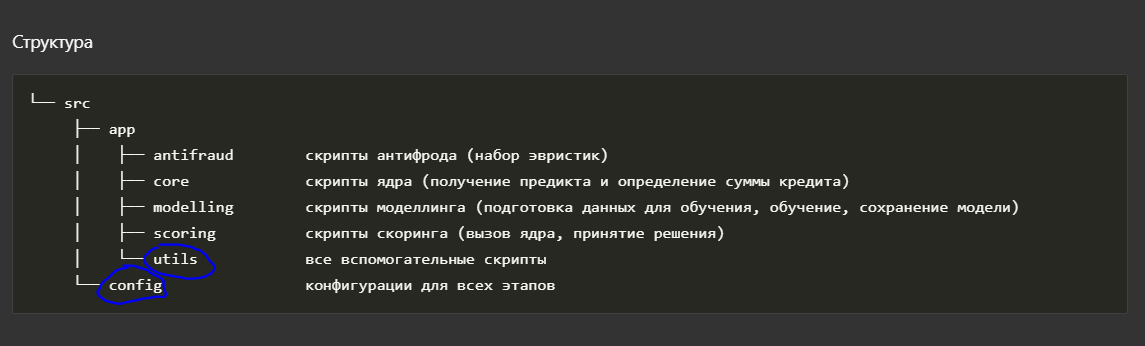

#### Бонусные задания:

1) Сделать класс для операций с БД вместо функций;

2) Проанализировать структуру, назначить в таблицах ключи и индексы запросами к БД.


<div style="float: right;">
<img src="attachment:image.png" width="50"/>
</div>


### Упражнения

In [ ]:
# вывести средний доход среди всех клиентов

,avg_income
0,170116.05986


In [19]:
query = """
SELECT AVG(AMT_INCOME_TOTAL) AS avg_income
FROM application_train_test;
"""
db_handler.get_df_from_query(query)

C:\Users\Denis\credit_scoring\src\app\utils\db_handler.py:80: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, self.connection, params=params)


,avg_income
0,170116.05986


In [ ]:
# вывести минимальный и максимальный возраст среди всех клиентов

In [ ]:
query = """
SELECT MIN(DAYS_BIRTH)/-365 AS max_age ,
       MAX(DAYS_BIRTH)/-365 AS min_age
FROM application_train_test;
"""
db_handler.get_df_from_query(query)

C:\Users\Denis\credit_scoring\src\app\utils\db_handler.py:80: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, self.connection, params=params)


,max_age,min_age
0,69,20


In [ ]:
# вывести количество мужчин и женщин

In [23]:

query = """
SELECT CODE_GENDER,
       COUNT(*) AS count
FROM application_train_test
GROUP BY CODE_GENDER;
"""
db_handler.get_df_from_query(query)

C:\Users\Denis\credit_scoring\src\app\utils\db_handler.py:80: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, self.connection, params=params)


,code_gender,count
0,F,235126
1,M,121125
2,XNA,4


In [ ]:
# вывести общую сумму, количество и среднюю сумму, запрошенную клиентами в кредит с авто и без

In [24]:
query = """
SELECT FLAG_OWN_CAR,
       COUNT(*) AS count_clients,
       SUM(AMT_CREDIT) AS total_credit_sum,
       AVG(AMT_CREDIT) AS avg_credit_sum
FROM application_train_test
GROUP BY FLAG_OWN_CAR;
"""
db_handler.get_df_from_query(query)

C:\Users\Denis\credit_scoring\src\app\utils\db_handler.py:80: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, self.connection, params=params)


,flag_own_car,count_clients,total_credit_sum,avg_credit_sum
0,N,235235,1.303948e+11,554317.381867
1,Y,121020,7.900023e+10,652786.569683


In [ ]:
# вывести доли клиентов с различным образованием

In [25]:
query = """
SELECT NAME_EDUCATION_TYPE,
       COUNT(*) AS count_clients,
       ROUND(COUNT(*) * 100.0 / SUM(COUNT(*)) OVER (), 2) AS percentage
FROM application_train_test
GROUP BY NAME_EDUCATION_TYPE;
"""
db_handler.get_df_from_query(query)

C:\Users\Denis\credit_scoring\src\app\utils\db_handler.py:80: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, self.connection, params=params)


,name_education_type,count_clients,percentage
0,Academic degree,205,0.06
1,Higher education,87379,24.53
2,Incomplete higher,12001,3.37
3,Lower secondary,4291,1.20
4,Secondary / secondary special,252379,70.84


In [ ]:
# подсчитать количество полных лет для клиентов, у которых есть во владении автомобиль и недвижимость.
# вывести топ 10 по возрастанию

In [27]:
query = """
SELECT SK_ID_CURR,
       FLOOR(ABS(DAYS_BIRTH) / 365) AS age_years
FROM application_train_test
WHERE FLAG_OWN_CAR = 'Y' AND FLAG_OWN_REALTY = 'Y'
ORDER BY age_years DESC
LIMIT 10;
"""
db_handler.get_df_from_query(query)


C:\Users\Denis\credit_scoring\src\app\utils\db_handler.py:80: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, self.connection, params=params)


,sk_id_curr,age_years
0,130958,68.0
1,137323,68.0
2,122068,68.0
3,127707,68.0
4,131457,68.0
5,132796,68.0
6,100703,68.0
7,112945,68.0
8,123002,68.0
9,137475,68.0


In [ ]:
# вывести тех клиентов, у кого доход на одного члена семьи в два раза больше, чем в среднем на одного члена семьи по выборке

In [28]:
query = """
WITH avg_income_per_family_member AS (
    SELECT AVG(AMT_INCOME_TOTAL / NULLIF(CNT_FAM_MEMBERS, 0)) AS avg_income_per_member
    FROM application_train_test
)
SELECT SK_ID_CURR,
       AMT_INCOME_TOTAL,
       CNT_FAM_MEMBERS,
       AMT_INCOME_TOTAL / NULLIF(CNT_FAM_MEMBERS, 0) AS income_per_member
FROM application_train_test, avg_income_per_family_member
WHERE AMT_INCOME_TOTAL / NULLIF(CNT_FAM_MEMBERS, 0) > 2 * avg_income_per_member;
"""
db_handler.get_df_from_query(query)

C:\Users\Denis\credit_scoring\src\app\utils\db_handler.py:80: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, self.connection, params=params)


,sk_id_curr,amt_income_total,cnt_fam_members,income_per_member
0,100002,202500.0,1.0,202500.0
1,100033,270000.0,1.0,270000.0
2,100053,202500.0,1.0,202500.0
3,100070,540000.0,1.0,540000.0
4,100079,225000.0,1.0,225000.0
...,...,...,...,...
27728,455940,202500.0,1.0,202500.0
27729,455959,225000.0,1.0,225000.0
27730,456009,225000.0,1.0,225000.0
27731,456119,247500.0,1.0,247500.0


In [ ]:
# вывести клиентов старше 60 лет по которым нет данных в bureau

In [29]:
query = """
SELECT app.SK_ID_CURR,
       FLOOR(ABS(app.DAYS_BIRTH) / 365) AS age_years
FROM application_train_test app
LEFT JOIN bureau b ON app.SK_ID_CURR = b.SK_ID_CURR
WHERE FLOOR(ABS(app.DAYS_BIRTH) / 365) > 60
  AND b.SK_ID_CURR IS NULL;
"""
db_handler.get_df_from_query(query)

C:\Users\Denis\credit_scoring\src\app\utils\db_handler.py:80: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, self.connection, params=params)


,sk_id_curr,age_years
0,249376,61.0
1,113210,64.0
2,234614,61.0
3,106076,64.0
4,124764,62.0
...,...,...
5051,369504,62.0
5052,352484,66.0
5053,144610,67.0
5054,432774,64.0


In [ ]:
# вывести женщин, у которых в истории bureau было больше двух кредитов, просроченных на 61 день и более
# отсортировать в порядке убывания по кол-ву таких кредитов

In [30]:
query = """
SELECT app.SK_ID_CURR,
       COUNT(b.CREDIT_DAY_OVERDUE) AS overdue_credits_count
FROM application_train_test app
JOIN bureau b ON app.SK_ID_CURR = b.SK_ID_CURR
WHERE app.CODE_GENDER = 'F'
  AND b.CREDIT_DAY_OVERDUE >= 61
GROUP BY app.SK_ID_CURR
HAVING COUNT(b.CREDIT_DAY_OVERDUE) > 2
ORDER BY overdue_credits_count DESC;
"""
db_handler.get_df_from_query(query)

C:\Users\Denis\credit_scoring\src\app\utils\db_handler.py:80: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, self.connection, params=params)


,sk_id_curr,overdue_credits_count
0,264144,5
1,142384,4
2,374345,3
3,375724,3
4,431820,3
5,114166,3
6,436084,3
7,337741,3


In [ ]:
# по данным из bureau (БКИ) расчитать долю просрочки в активных займах для каждого клиента
# вывести топ 7 мужчин с наибольшей суммой просрочки, указав для них, помимо прочего,
# сумму активных кредитов и суммы всех кредитов (активных и закрытых).

In [31]:
query = """
WITH active_loans AS (
    SELECT b.SK_ID_CURR,
           SUM(b.AMT_CREDIT_SUM) AS total_active_credit_sum,
           SUM(b.AMT_CREDIT_SUM_OVERDUE) AS total_overdue_sum
    FROM bureau b
    WHERE b.CREDIT_ACTIVE = 'Active'
    GROUP BY b.SK_ID_CURR
),
all_loans AS (
    SELECT b.SK_ID_CURR,
           SUM(b.AMT_CREDIT_SUM) AS total_credit_sum
    FROM bureau b
    GROUP BY b.SK_ID_CURR
)
SELECT app.SK_ID_CURR,
       app.CODE_GENDER,
       al.total_active_credit_sum,
       al.total_overdue_sum,
       al.total_overdue_sum / NULLIF(al.total_active_credit_sum, 0) AS overdue_ratio,
       all_loans.total_credit_sum
FROM application_train_test app
JOIN active_loans al ON app.SK_ID_CURR = al.SK_ID_CURR
JOIN all_loans ON app.SK_ID_CURR = all_loans.SK_ID_CURR
WHERE app.CODE_GENDER = 'M'
ORDER BY al.total_overdue_sum DESC
LIMIT 7;
"""
db_handler.get_df_from_query(query)

C:\Users\Denis\credit_scoring\src\app\utils\db_handler.py:80: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, self.connection, params=params)


,sk_id_curr,code_gender,total_active_credit_sum,total_overdue_sum,overdue_ratio,total_credit_sum
0,435405,M,3690000.0,3681063.00,0.997578,4054000.5
1,427996,M,4231615.5,1571697.00,0.371418,7431583.5
2,394113,M,1530000.0,1332472.50,0.870897,1825801.0
3,266765,M,1350000.0,1224474.90,0.907018,1421955.0
4,167085,M,158404.5,780192.00,4.925314,176404.5
5,154595,M,990000.0,742491.00,0.749991,4245754.5
6,262411,M,1318500.0,709669.25,0.538240,1773000.0
